# Tiny VAD Student Training

This notebook mirrors the production training script while keeping the loop
small enough for experimentation. It demonstrates how to:

1. Load the canonical YAML config
2. Instantiate `TinyVADChunkDataset` and PyTorch dataloaders
3. Train the `TinyVADModel` with MSE loss against Silero probabilities
4. Plot loss curves and compare student vs teacher outputs on a held-out chunk

> Training consumes the preprocessed files stored in `H:/wenet_data_processed/chunks/audio`.
> Each `chunk_XXXXX.npy` bundles `features`, `teacher_probs`, and `hard_labels`, so no
> `chunks/labels` directory is required.



In [1]:
from __future__ import annotations

import json

import matplotlib.pyplot as plt
import numpy as np
import torch

from vad_distill.config import load_config
from vad_distill.config.data_paths import resolve_paths
from vad_distill.tiny_vad.dataset import build_dataloader, build_datasets
from vad_distill.tiny_vad.model import build_tiny_vad_model
from vad_distill.tiny_vad.train import run_training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda


In [2]:
config = load_config()
training_cfg = config.setdefault("training", {})
training_cfg.update(
    {
        "epochs": 3,
        "batch_size": training_cfg.get("batch_size", 32),
        "limit_train_chunks": training_cfg.get("limit_train_chunks", 1024),
        "limit_val_chunks": training_cfg.get("limit_val_chunks", 256),
        "use_random_subset": True,
        "subset_size": 50000,
    }
)
training_cfg.setdefault("early_stopping", {}).update({"enabled": True, "patience": 3})
training_cfg.setdefault("log_interval", 100)

print("Training overrides (not persisted):")
print(
    json.dumps(
        {
            "epochs": training_cfg["epochs"],
            "batch_size": training_cfg["batch_size"],
            "limit_train_chunks": training_cfg["limit_train_chunks"],
            "limit_val_chunks": training_cfg["limit_val_chunks"],
            "use_random_subset": training_cfg["use_random_subset"],
            "subset_size": training_cfg["subset_size"],
        },
        indent=2,
    )
)

resolved_paths = resolve_paths(config.get("paths", {}))
for key in ("checkpoint_dir", "logs_dir", "onnx_dir"):
    resolved_paths[key].mkdir(parents=True, exist_ok=True)
config["paths"] = resolved_paths
print("\nResolved paths:")
print(json.dumps({k: str(v) for k, v in resolved_paths.items()}, indent=2))


Training overrides (not persisted):
{
  "epochs": 3,
  "batch_size": 32,
  "limit_train_chunks": null,
  "limit_val_chunks": null,
  "use_random_subset": true,
  "subset_size": 50000
}

Resolved paths:
{
  "data_root": "H:\\wenet_data_processed",
  "chunks_dir": "H:\\wenet_data_processed\\chunks",
  "features_dir": "H:\\wenet_data_processed\\features",
  "metadata_dir": "H:\\wenet_data_processed\\metadata",
  "teacher_prob_dir": "H:\\wenet_data_processed\\chunks",
  "checkpoint_dir": "H:\\Personal Projects\\VAD_mini\\outputs\\checkpoints",
  "logs_dir": "H:\\Personal Projects\\VAD_mini\\outputs\\logs",
  "onnx_dir": "H:\\Personal Projects\\VAD_mini\\outputs\\export"
}


In [3]:
seed = int(config.get("seed", 2025))
torch.manual_seed(seed)
np.random.seed(seed)
paths = config["paths"]
train_subset, val_subset = build_datasets(config, seed)
print(f"Train subset: {len(train_subset):,} chunks")
print(f"Val subset  : {len(val_subset):,} chunks")


Train subset: 1,745,027 chunks
Val subset  : 193,891 chunks


In [4]:
summary = run_training(config)
summary


train:   0%|          | 4/1563 [00:46<3:48:40,  8.80s/it, loss=0.0064] 

[epoch 1] batch=0 loss=0.017938


train:   7%|▋         | 102/1563 [00:50<00:57, 25.39it/s, loss=0.0054]

[epoch 1] batch=100 loss=0.003720


train:  13%|█▎        | 203/1563 [00:54<00:50, 26.80it/s, loss=0.0037]

[epoch 1] batch=200 loss=0.005390


train:  19%|█▉        | 303/1563 [00:58<00:46, 27.09it/s, loss=0.0047]

[epoch 1] batch=300 loss=0.003726


train:  26%|██▌       | 403/1563 [01:01<00:43, 26.82it/s, loss=0.0039]

[epoch 1] batch=400 loss=0.004999


train:  32%|███▏      | 503/1563 [01:05<00:38, 27.34it/s, loss=0.0050]

[epoch 1] batch=500 loss=0.003682


train:  39%|███▊      | 603/1563 [01:09<00:34, 27.56it/s, loss=0.0051]

[epoch 1] batch=600 loss=0.003423


train:  45%|████▍     | 703/1563 [01:13<00:31, 26.91it/s, loss=0.0038]

[epoch 1] batch=700 loss=0.002375


train:  51%|█████▏    | 803/1563 [01:16<00:28, 26.40it/s, loss=0.0040]

[epoch 1] batch=800 loss=0.004215


train:  58%|█████▊    | 906/1563 [01:21<00:17, 36.64it/s, loss=0.0028]

[epoch 1] batch=900 loss=0.003185


train:  65%|██████▍   | 1014/1563 [01:22<00:06, 84.11it/s, loss=0.0045]

[epoch 1] batch=1000 loss=0.004226


train:  71%|███████   | 1107/1563 [01:23<00:05, 87.11it/s, loss=0.0039]

[epoch 1] batch=1100 loss=0.002872


train:  78%|███████▊  | 1214/1563 [01:24<00:03, 88.71it/s, loss=0.0041]

[epoch 1] batch=1200 loss=0.003979


train:  84%|████████▍ | 1318/1563 [01:26<00:02, 88.82it/s, loss=0.0046]

[epoch 1] batch=1300 loss=0.001825


train:  90%|█████████ | 1408/1563 [01:27<00:01, 81.67it/s, loss=0.0025]

[epoch 1] batch=1400 loss=0.004446


train:  97%|█████████▋| 1515/1563 [01:28<00:00, 92.75it/s, loss=0.0029]

[epoch 1] batch=1500 loss=0.003617


train:   1%|          | 9/1563 [00:47<1:38:14,  3.79s/it, loss=0.0044] 

[epoch 2] batch=0 loss=0.004259


train:   7%|▋         | 105/1563 [00:50<00:56, 25.70it/s, loss=0.0033]

[epoch 2] batch=100 loss=0.002294


train:  13%|█▎        | 205/1563 [00:54<00:51, 26.46it/s, loss=0.0052]

[epoch 2] batch=200 loss=0.004612


train:  19%|█▉        | 304/1563 [00:58<00:46, 26.88it/s, loss=0.0014]

[epoch 2] batch=300 loss=0.003256


train:  26%|██▌       | 404/1563 [01:02<00:43, 26.42it/s, loss=0.0057]

[epoch 2] batch=400 loss=0.003144


train:  32%|███▏      | 504/1563 [01:06<00:40, 25.86it/s, loss=0.0023]

[epoch 2] batch=500 loss=0.004205


train:  39%|███▊      | 604/1563 [01:10<00:36, 26.54it/s, loss=0.0038]

[epoch 2] batch=600 loss=0.004078


train:  45%|████▌     | 704/1563 [01:13<00:32, 26.58it/s, loss=0.0043]

[epoch 2] batch=700 loss=0.001621


train:  51%|█████▏    | 804/1563 [01:17<00:29, 25.72it/s, loss=0.0025]

[epoch 2] batch=800 loss=0.002389


train:  58%|█████▊    | 904/1563 [01:21<00:24, 26.55it/s, loss=0.0037]

[epoch 2] batch=900 loss=0.004272


train:  64%|██████▍   | 1004/1563 [01:25<00:21, 25.85it/s, loss=0.0022]

[epoch 2] batch=1000 loss=0.003238


train:  71%|███████   | 1104/1563 [01:29<00:17, 26.05it/s, loss=0.0027]

[epoch 2] batch=1100 loss=0.002999


train:  77%|███████▋  | 1204/1563 [01:33<00:14, 24.89it/s, loss=0.0029]

[epoch 2] batch=1200 loss=0.002947


train:  83%|████████▎ | 1304/1563 [01:37<00:11, 22.95it/s, loss=0.0040]

[epoch 2] batch=1300 loss=0.003675


train:  90%|████████▉ | 1404/1563 [01:41<00:06, 26.14it/s, loss=0.0040]

[epoch 2] batch=1400 loss=0.003833


train:  96%|█████████▌| 1504/1563 [01:45<00:02, 25.34it/s, loss=0.0036]

[epoch 2] batch=1500 loss=0.002672


train:   0%|          | 5/1563 [00:46<2:59:59,  6.93s/it, loss=0.0031] 

[epoch 3] batch=0 loss=0.005662


train:   7%|▋         | 105/1563 [00:50<00:57, 25.15it/s, loss=0.0042]

[epoch 3] batch=100 loss=0.002943


train:  13%|█▎        | 203/1563 [00:54<00:56, 24.18it/s, loss=0.0016]

[epoch 3] batch=200 loss=0.003056


train:  19%|█▉        | 303/1563 [00:58<00:44, 28.20it/s, loss=0.0031]

[epoch 3] batch=300 loss=0.002512


train:  26%|██▌       | 403/1563 [01:01<00:40, 28.31it/s, loss=0.0036]

[epoch 3] batch=400 loss=0.002909


train:  32%|███▏      | 502/1563 [01:05<00:42, 25.07it/s, loss=0.0033]

[epoch 3] batch=500 loss=0.003570


train:  39%|███▊      | 602/1563 [01:09<00:35, 27.10it/s, loss=0.0023]

[epoch 3] batch=600 loss=0.002698


train:  45%|████▍     | 702/1563 [01:13<00:30, 28.03it/s, loss=0.0031]

[epoch 3] batch=700 loss=0.003652


train:  51%|█████▏    | 802/1563 [01:16<00:27, 27.91it/s, loss=0.0042]

[epoch 3] batch=800 loss=0.002325


train:  58%|█████▊    | 902/1563 [01:20<00:24, 26.76it/s, loss=0.0045]

[epoch 3] batch=900 loss=0.001978


train:  64%|██████▍   | 1002/1563 [01:25<00:24, 22.91it/s, loss=0.0033]

[epoch 3] batch=1000 loss=0.002057


train:  71%|███████   | 1102/1563 [01:29<00:17, 26.90it/s, loss=0.0021]

[epoch 3] batch=1100 loss=0.002397


train:  77%|███████▋  | 1202/1563 [01:33<00:14, 25.44it/s, loss=0.0038]

[epoch 3] batch=1200 loss=0.002647


train:  83%|████████▎ | 1302/1563 [01:37<00:10, 25.79it/s, loss=0.0019]

[epoch 3] batch=1300 loss=0.003093


train:  90%|████████▉ | 1402/1563 [01:41<00:06, 24.95it/s, loss=0.0027]

[epoch 3] batch=1400 loss=0.003138


train:  96%|█████████▌| 1502/1563 [01:45<00:02, 27.17it/s, loss=0.0025]

[epoch 3] batch=1500 loss=0.003366


{'best_val': 0.0032468363970518882,
 'history_path': 'H:\\Personal Projects\\VAD_mini\\outputs\\logs\\training\\checkpoints_train_history.json'}

In [5]:
with open(summary["history_path"], "r", encoding="utf-8") as handle:
    history = json.load(handle)
history[-1]


{'epoch': 3,
 'train_loss': 0.0034145129025542555,
 'val_loss': 0.0032468363970518882,
 'lr': 0.001,
 'grad_norm': 0.013242435343956822}

In [6]:
# Training loop is handled by run_training(config).
history

[{'epoch': 1,
  'train_loss': 0.0042635489441245865,
  'val_loss': 0.0038023977559451753,
  'lr': 0.001,
  'grad_norm': 0.014557155543343615},
 {'epoch': 2,
  'train_loss': 0.0035755553115808755,
  'val_loss': 0.003899938706078078,
  'lr': 0.001,
  'grad_norm': 0.013892973835746295},
 {'epoch': 3,
  'train_loss': 0.0034145129025542555,
  'val_loss': 0.0032468363970518882,
  'lr': 0.001,
  'grad_norm': 0.013242435343956822}]

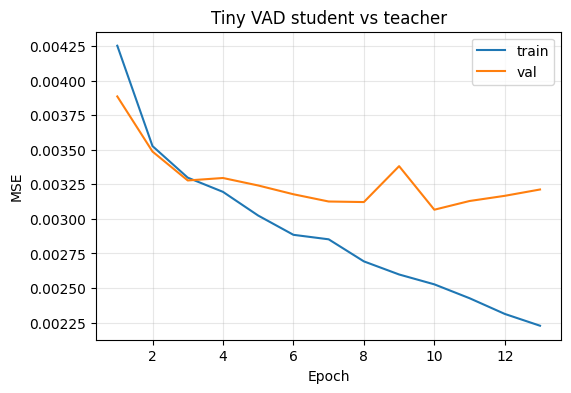

In [ ]:
epochs = [item["epoch"] for item in history]
train_curve = [item["train_loss"] for item in history]
val_curve = [item["val_loss"] for item in history]

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_curve, label="train")
plt.plot(epochs, val_curve, label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Tiny VAD student vs teacher")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



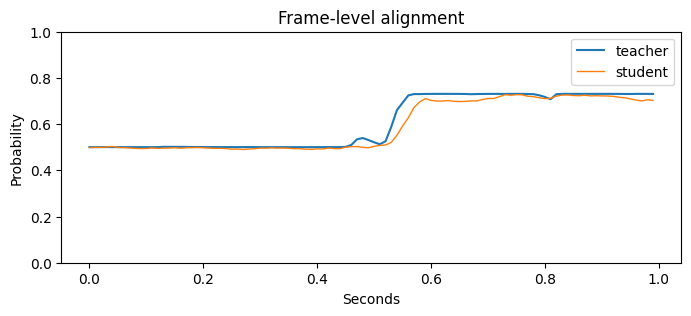

In [ ]:
paths = config["paths"]
checkpoint_dir = paths["checkpoint_dir"]
state = torch.load(checkpoint_dir / "best.pt", map_location=device)

model = build_tiny_vad_model(config).to(device)
model.load_state_dict(state["model_state_dict"])
model.eval()

_, val_subset = build_datasets(config, seed)
val_loader = build_dataloader(val_subset, config["training"], shuffle=False)

sample_features, sample_teacher = next(iter(val_loader))
with torch.no_grad():
    sample_features = sample_features.float().to(device, non_blocking=True)
    student_probs = torch.sigmoid(model(sample_features)).cpu().numpy()

time_axis = np.arange(student_probs.shape[1]) * 0.01
plt.figure(figsize=(8, 3))
plt.plot(time_axis, sample_teacher[0].numpy(), label="teacher", linewidth=1.5)
plt.plot(time_axis, student_probs[0], label="student", linewidth=1.0)
plt.ylim(0, 1)
plt.xlabel("Seconds")
plt.ylabel("Probability")
plt.title("Frame-level alignment")
plt.legend()
plt.show()

